<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Topic-modelling" data-toc-modified-id="Topic-modelling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Topic modelling</a></span><ul class="toc-item"><li><span><a href="#Set-working-directory" data-toc-modified-id="Set-working-directory-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Set working directory</a></span></li><li><span><a href="#Alert-Function" data-toc-modified-id="Alert-Function-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Alert Function</a></span></li><li><span><a href="#Import-Data" data-toc-modified-id="Import-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Import Data</a></span></li><li><span><a href="#Stop-Words" data-toc-modified-id="Stop-Words-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Stop Words</a></span></li><li><span><a href="#Model-Preprocessing-Functions" data-toc-modified-id="Model-Preprocessing-Functions-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Model Preprocessing Functions</a></span></li></ul></li><li><span><a href="#Junk" data-toc-modified-id="Junk-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Junk</a></span></li></ul></div>

# Topic modelling

**Frequency of dominant topics in documents**


    Date: 03/12/19
    Author: Avery
    Source Code: Simone and Toni
    Last Updated: 02/02/20

Purpose, generate all the data for the pca vis

In [90]:
# Plotting tools
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import re
import numpy as np
import pandas as pd

#NLTK
import nltk
# nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel

# spacy for lemmatization
import spacy
if 'nlp' not in locals():
    nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
#     nlp = spacy.load('en', disable=['parser', 'ner'])

import gc
import os
from glob import glob
from IPython.display import Audio, display

# Text Analysis (uncomment if running for first time)
# ! wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# ! unzip mallet-2.0.8.zip
MALLET_PATH = 'mallet-2.0.8/bin/mallet'

## Set working directory

In [6]:
from pathlib import *
#current working directory
current_dir = Path.cwd()
#go up 1 level to the 1st parent directory
Par1_dir = current_dir.parents[0]

Par1_dir

PosixPath('/Users/averysoh/Google Drive (racass1234@gmail.com)')

## Alert Function

In [7]:
def allDone():
    '''this function outputs a short audio when called. 
    Typically this is used to signal a task completion'''
    
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [8]:
allDone()

## Import Data

Whats happening here:
- Importing a test file to process the data and see the visualisation 
- slice the dataframe into yearly slices, then take a random sample of size=100k for each year and save the DF samples in a list.
- delete the DF imported and call for garbage collection to clear the memory

Reason for sampling will be mentioned below in another step

In [91]:
#set the file and data directories
# df_filename = 'globe_Machine Learning_all_.csv'

ai_or_dl = 'ai'
df_filename = 'globe_Deep Learning_4_inc.csv' # CHANGE THIS
df_data_dir = Par1_dir /'AI Project'/'Python Env' / 'DataFrames'/ 'AI_datasets' / 'globe_ai_13_18'/ df_filename

#import only the required columns from the DF
df = pd.read_csv(df_data_dir, usecols=['tweet', 'date/time', 'search'])

#find dataframe's search word, and remove quotations f present
search_word = df.head(1).search.item().replace('"', '').replace("'","")
#drop unused columns
df = df.loc[:, ['tweet', 'date/time']]

df_list = []
# #create a random Sample of 100k for each year & drop NAs
for x in range(2013,2019):
    globals()['df_%s' % x] = df.loc[(df['date/time']>=str(x)+'-01-01 00:00:00+00:00') & (df['date/time']<str(x+1)+'-01-01 00:00:00+00:00'),: ].copy()
    n = min(100000, len(globals()['df_%s' % x]))
    globals()['df_%s' % x] = globals()['df_%s' % x].sample(n=n, random_state=11).dropna(subset=['tweet'])
    df_list.append(globals()['df_%s' % x])
    del globals()['df_%s' % x]

#delete the big DF
del df
gc.collect()


/anaconda3/envs/ai_project/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: `item` has been deprecated and will be removed in a future version
  if sys.path[0] == '':


14

In [92]:
df = pd.concat(df_list)
df.head()

,tweet,date/time
5216,Today its big data conférence at poly Montreal...,2013-05-30 14:38:28+00:00
8435,@commentisfree @wonderfrancis Elite or no elit...,2013-10-02 17:57:32+00:00
2041,"the #NeuralNetworks, the #deepLearning and the...",2013-02-26 01:02:06+00:00
6330,Dr Ross is so passionalte about Deep Learning....,2013-06-20 23:41:20+00:00
7963,-_- We’re on the cusp of deep learning for the...,2013-08-17 03:30:27+00:00


In [93]:
search_word

'Deep Learning'

## Stop Words

Process developed by Toni, refer to file "Yearly Topic Models.ipynb" in "Pcode" folder

In [94]:
# NLTK Stop words
from nltk.corpus import stopwords

#NLTK english stopwords
stop_words = stopwords.words('english')
#extend the list with a peronal list of stopwords
stop_words.extend(['from', 'need','thank','thing','something', 'see', 'say', 'well','people', 'change', 'com',\
                   'go', 'put', 'give','twitter','pic', \
                   'subject', 're', 'edu', 'could', 'be', 'make', 'not', 'make','find','let','may','see', 'would',\
                   'come', 'sure', 'ever', 'tell', 'use', 'not', 'doing', 'be', 'get','want'])
#extend the search word
stop_words.extend(['artificial intelligence', '#ai', '#ml', '#nlp', 'analytics', 'data mining',
                  'deep mining', 'machine learning', 'natural language processing', 'neural network'
                  'pattern recognition'])

## Model Preprocessing Functions

Process developed by Toni, refer to file "Yearly Topic Models.ipynb" in "Pcode" folder

In [95]:
### Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
###Remove Stopwords, Make Bigrams and Lemmatize
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(bigram_mod, texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


def lda_preprocessing(df):
    ### Remove emails, newline characters, and links
    # Convert to list
    data = df.tweet.values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', str(tweet)) for tweet in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', tweet) for tweet in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", tweet) for tweet in data]

    #Remove links
    data = [re.sub(r"http\S+", "", tweet) for tweet in data]

    #make lower case
    data = [tweet.lower() for tweet in data]
    
    # Tokenize words and Clean-up text
    data_words = list(sent_to_words(data))

    ###Creating Bigram and Trigram Models
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(bigram_mod, data_words_nostops)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN','ADJ','ADV', 'VERB'])
    data_lemmatized = remove_stopwords(data_lemmatized)

    ###Create the Dictionary and Corpus needed for Topic Modeling¶
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

        
    return data_lemmatized, corpus, id2word

In [96]:
dates = pd.DataFrame()
dates['date'] = df['date/time']
dates['year'] = dates['date'].str.split('-', expand=True)[0]
dates = dates.reset_index(drop=True) 
dates = dates.reset_index()
dates = dates.rename(columns={'index':'doc_id'})

dates

,doc_id,date,year
0,0,2013-05-30 14:38:28+00:00,2013
1,1,2013-10-02 17:57:32+00:00,2013
2,2,2013-02-26 01:02:06+00:00,2013
3,3,2013-06-20 23:41:20+00:00,2013
4,4,2013-08-17 03:30:27+00:00,2013
...,...,...,...
464247,464247,2018-08-10 17:00:00+00:00,2018
464248,464248,2018-12-02 11:08:12+00:00,2018
464249,464249,2018-07-01 14:58:48+00:00,2018
464250,464250,2018-02-27 09:51:07+00:00,2018


In [97]:
# from multiprocessing import cpu_count
# Testing with sample DF
# 2013 df testing

#df = df_list[0]
#data_lemmatized, CORPUS, id2word = lda_preprocessing(df)




In [98]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from multiprocessing import cpu_count

#     df = df_list[1]

data_lemmatized, CORPUS, id2word = lda_preprocessing(df)

#get current working directory
cwd = os.getcwd()

#set the number of workers to the number of cores available
workers = cpu_count() 

# Set number of topics
NUM_TOPICS = 20

ldamallet = LdaMallet(MALLET_PATH, corpus=CORPUS, num_topics=NUM_TOPICS, id2word=id2word,
                                  random_seed =11,workers=workers)

# Transform model weights from MALLET to GENSIM
lda_model = malletmodel2ldamodel(ldamallet)

# Save Topic meanings
topic_content = pd.DataFrame(ldamallet.print_topics(num_topics=NUM_TOPICS, num_words=100))
topic_content = topic_content.rename(columns={0:'topic_n', 1:'content'})

filename = 'topic_content_' + search_word + '.csv'
foldername = 'pca_data'
save_dir = Par1_dir /'AI Project'/'Avery_output' / foldername / ai_or_dl / filename
topic_content.to_csv(save_dir, index=True)

############################
# Get doc-topic probability#
############################

# get transformed corpus as per the LDA model
TRANSF_CORPUS = lda_model.get_document_topics(CORPUS)

# rearrange data on document-topic pairs probabilities
DOC_TOPIC_M = []

for id, doc in enumerate(TRANSF_CORPUS):
    for topic in np.arange(0, 20, 1):
        topic_n = doc[topic][0]
        topic_prob = doc[topic][1] 
        DOC_TOPIC_M.append([id, topic, topic_prob])

DF = pd.DataFrame(DOC_TOPIC_M)

# rename columns
OLD_NAMES = [0, 1, 2]
NEW_NAMES = ['doc_id', 'topic_n', 'prob']
COLS = dict(zip(OLD_NAMES, NEW_NAMES))
DF.rename(columns=COLS, inplace=True)

DF1 = DF.copy() # Checkpoint
DF1 = DF1.pivot_table(index='doc_id', columns='topic_n', values='prob', aggfunc=np.mean)
DF1 = DF1.reset_index()

# Keep only dominant topic for vis
GR = DF.groupby('doc_id')
DF.loc[:, 'max'] = GR['prob'].transform(np.max)
DF.loc[:, 'first_topic'] = 0
DF.loc[DF['prob'] == DF['max'], 'first_topic'] = 1
FIRST_TOPIC = DF.loc[DF['first_topic'] == 1]

# Record Dates
dates = pd.DataFrame()
dates['date'] = df['date/time']
dates['year'] = dates['date'].str.split('-', expand=True)[0]
dates = dates.reset_index(drop=True) 
dates = dates.reset_index()
dates = dates.rename(columns={'index':'doc_id'})

# Merge to keep the First order
DF2 = pd.merge(DF1, FIRST_TOPIC, how='left', on='doc_id')
DF2 = pd.merge(DF2, dates, how='left', on='doc_id') 

# write data to file
filename = search_word + '.csv'
foldername = 'pca_data'
save_dir = Par1_dir /'AI Project'/'Avery_output' / foldername / ai_or_dl / filename
DF2.to_csv(save_dir, index=True)


# # Store a dataset for visualistion later
# year_name = min(df.loc[:,'date/time'])[:4]
# VIS_DF = pd.DataFrame(FIRST_TOPIC.topic_n.value_counts()).reset_index()
# # Add a rank level
# VIS_DF.index += 1 
# VIS_DF.reset_index(inplace=True)

# # rename columns
# OLD_NAMES = ['level_0', 'index', 'topic_n']
# NEW_NAMES = ['rank', 'topic_n', 'freq']
# COLS = dict(zip(OLD_NAMES, NEW_NAMES))
# VIS_DF.rename(columns=COLS, inplace=True)

# # Add the current year
# VIS_DF['year'] = int(year_name)

# vis_filename = year_name + '.csv'
# foldername = search_word + '_vis_df'
# save_dir2 = Par1_dir /'AI Project'/'Avery_output' / foldername / vis_filename
# VIS_DF.to_csv(save_dir2, index=True)




allDone()

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def pca_data(df):

    df1 = df.loc[:, '0':'19']
    X = df1.to_numpy()

    df2 = df.drop(columns=df1.columns)
    df2 = df2[['topic_n', 'prob', 'date', 'year']]
    scaler = StandardScaler() # instantiate
    scaler.fit(X) # compute the mean and standard which will be used in the next command
    X_scaled = scaler.transform(X)
    # fit and transform can be applied together and I leave that for simple exercise
    # we can check the minimum and maximum of the scaled features which we expect to be 0 and 1
    # print ("after scaling minimum", X_scaled.min(axis=0))
    pca = PCA(n_components=2)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)
    vdf = pd.DataFrame()
    vdf['x'] = X_pca[:,0]
    vdf['y'] = X_pca[:,1]
    # vdf = vdf.reset_index()
    # vdf = vdf.rename(columns={'index':'doc_id'})
    vdf = pd.merge(vdf, df2, how='left', left_index=True, right_index=True)

    return vdf

filename = search_word + '.csv'
foldername = 'pca_data'
save_dir = Par1_dir /'AI Project'/'Avery_output' / foldername / ai_or_dl / filename

DF3 = pd.read_csv(save_dir)
vdf = pca_data(DF3)
filename = 'vis_ready_' + search_word + '.csv'
foldername = 'pca_data'
save_dir = Par1_dir /'AI Project'/'Avery_output' / foldername / ai_or_dl / filename
vdf.to_csv(save_dir, index=False)

In [105]:
DF2.loc[:,'0':'19']

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [0] of <class 'int'>

In [81]:
topic_content = pd.DataFrame(ldamallet.print_topics(num_topics=NUM_TOPICS, num_words=100))
topic_content = topic_content.rename(columns={0:'topic_n', 1:'content'})

filename = 'topic_content_' + search_word + '.csv'
foldername = 'pca_data'
save_dir = Par1_dir /'AI Project'/'Avery_output' / foldername / ai_or_dl / filename
topic_content.to_csv(save_dir, index=True)

# Junk

In [19]:
# Find all the file names in the folder for the visualisation
df_files = sorted(glob(str(Par1_dir /'AI Project'/'Avery_output'/ 'Machine Learning_vis_df'/'*')))
df_files

['/Users/averysoh/Google Drive (racass1234@gmail.com)/AI Project/Avery_output/Machine Learning_vis_df/2013.csv',
 '/Users/averysoh/Google Drive (racass1234@gmail.com)/AI Project/Avery_output/Machine Learning_vis_df/2014.csv',
 '/Users/averysoh/Google Drive (racass1234@gmail.com)/AI Project/Avery_output/Machine Learning_vis_df/2015.csv',
 '/Users/averysoh/Google Drive (racass1234@gmail.com)/AI Project/Avery_output/Machine Learning_vis_df/2016.csv',
 '/Users/averysoh/Google Drive (racass1234@gmail.com)/AI Project/Avery_output/Machine Learning_vis_df/2017.csv',
 '/Users/averysoh/Google Drive (racass1234@gmail.com)/AI Project/Avery_output/Machine Learning_vis_df/2018.csv']

In [8]:
# Read All the files from df_files
vis_list=[]

for x in range(len(df_files)):
    globals()['df_%s' % df_files[x][-8:-4]] = pd.read_csv(df_files[x])
    vis_list.append(globals()['df_%s' % df_files[x][-8:-4]])
    del globals()['df_%s' % df_files[x][-8:-4]]
    gc.collect()
    
    
# Store as a single df
vis_df = pd.concat(vis_list)
vis_df.drop(columns=['Unnamed: 0'], inplace=True)
vis_df

,rank,topic_n,freq,year
0,1,13,5451,2013
1,2,18,5068,2013
2,3,8,4785,2013
3,4,10,4766,2013
4,5,4,4719,2013
...,...,...,...,...
15,16,19,5452,2018
16,17,15,5203,2018
17,18,10,5167,2018
18,19,7,5097,2018


In [9]:
# Plotting

from bokeh.io import output_notebook,output_file, show, save
output_notebook()

from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.plotting import figure
from bokeh.palettes import Blues



# x=df_2013['year']
# y= df_2013['topic_n']
size = vis_df['freq']/150

source = ColumnDataSource(vis_df)

t1 = vis_df[vis_df.topic_n == 1]
st1 = ColumnDataSource(t1)

t2 = vis_df[vis_df.topic_n == 2]
st2 = ColumnDataSource(t2)

t3 = vis_df[vis_df.topic_n == 3]
st3 = ColumnDataSource(t3)

cmap = LinearColorMapper(palette=Blues[256], 
                         low = min(vis_df["rank"]), 
                         high = max(vis_df["rank"]))

p = figure(plot_width=800, plot_height=1000, title="Dominant Topic Frequency", toolbar_location=None, tools="")

p.line(x='year', y='rank', source=st1, line_width = 4, line_color = 'grey', line_alpha=0.5)
p.line(x='year', y='rank', source=st2, line_width = 4, line_color = 'grey', line_alpha=0.5)
p.line(x='year', y='rank', source=st3, line_width = 4, line_color = 'grey', line_alpha=0.5)

p.circle(x='year', y='rank', size = 30,source=source, 
         fill_color={"field":"rank", "transform":cmap})

# for x in vis_df['topic_n'].unique():
#     vis_df
#     src = ColumnDataSource(vis_df[vis_df[topic_n] == x])


p.add_tools(HoverTool(tooltips=[('Topic Number', '@topic_n'),
                                ("Frequency as Dominant Topic", "@freq"),
                                ("Rank", '@rank')]))

from bokeh.models import ColorBar
bar = ColorBar(color_mapper=cmap, location=(0,0))
p.add_layout(bar, "right")



show(p)

# TO save the file as HTML
#output_file("/Users/averysoh/Google Drive (racass1234@gmail.com)/AI Project/Avery_output/Dominant_topic.html")
#save(p)

Loading BokehJS ...

In [46]:
Blues[256].reverse()

In [61]:
for x in vis_df['topic_n'].unique():
    print(x)

13
18
8
10
4
9
7
17
19
15
16
11
3
2
12
0
1
14
5
6


In [70]:
vis_df[vis_df[topic_n] == 19]

KeyError: 19

In [73]:
vis_df[vis_df.topic_n == 1]

,rank,topic_n,freq,year
16,17,1,4213,2013
6,7,1,6248,2014
0,1,1,7755,2015
18,19,1,5497,2016
4,5,1,6035,2017
10,11,1,5665,2018


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
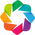

   source  target  value
0       1       0      1
1       2       0      8
2       3       0     10
3       3       2      6
4       4       0      1


In [16]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

hv.extension('bokeh')

links = pd.DataFrame(data['links'])
print(links.head())

In [15]:
data

{'nodes': [{'name': 'Myriel', 'group': 1},
  {'name': 'Napoleon', 'group': 1},
  {'name': 'Mlle.Baptistine', 'group': 1},
  {'name': 'Mme.Magloire', 'group': 1},
  {'name': 'CountessdeLo', 'group': 1},
  {'name': 'Geborand', 'group': 1},
  {'name': 'Champtercier', 'group': 1},
  {'name': 'Cravatte', 'group': 1},
  {'name': 'Count', 'group': 1},
  {'name': 'OldMan', 'group': 1},
  {'name': 'Labarre', 'group': 2},
  {'name': 'Valjean', 'group': 2},
  {'name': 'Marguerite', 'group': 3},
  {'name': 'Mme.deR', 'group': 2},
  {'name': 'Isabeau', 'group': 2},
  {'name': 'Gervais', 'group': 2},
  {'name': 'Tholomyes', 'group': 3},
  {'name': 'Listolier', 'group': 3},
  {'name': 'Fameuil', 'group': 3},
  {'name': 'Blacheville', 'group': 3},
  {'name': 'Favourite', 'group': 3},
  {'name': 'Dahlia', 'group': 3},
  {'name': 'Zephine', 'group': 3},
  {'name': 'Fantine', 'group': 3},
  {'name': 'Mme.Thenardier', 'group': 4},
  {'name': 'Thenardier', 'group': 4},
  {'name': 'Cosette', 'group': 5},
  

In [17]:
nodes = hv.Dataset(pd.DataFrame(data['nodes']), 'index')
nodes.data

,index,name,group
0,0,Myriel,1
1,1,Napoleon,1
2,2,Mlle.Baptistine,1
3,3,Mme.Magloire,1
4,4,CountessdeLo,1
...,...,...,...
72,72,Toussaint,5
73,73,Child1,10
74,74,Child2,10
75,75,Brujon,4


In [18]:
chord = hv.Chord((links, nodes)).select(value=(5, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='name', node_color=dim('index').str()))

:Chord   [source,target]   (value)

In [ ]:
CO

In [ ]:
from gensim.test.utils import common_corpus
from gensim.models import LdaSeqModel

ldaseq = LdaSeqModel(corpus=common_corpus, time_slice=[2, 4, 3], num_topics=2, chunksize=1)